## Exploratory Data Analysis on PPEP Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from __future__ import division
import _pickle as pickle

In [2]:
def data_cleaning_function(filepath):
    '''
    load data into a pandas dataframe from the csv file
    '''
    df_ = pd.read_csv(filepath)
    '''
    Drop the last five columns which were non user data generated when downloading
    data from Salesforce
    '''
    df_ = df_.ix[:3570,:]

    '''
    keep only the data that has DOC numbers
    '''
    df_.dropna(subset =['DOC / Agency #'], inplace= True)

    '''
    create a count of recidivism events for each person
    '''
    recidivism_events = df_.groupby('DOC / Agency #').count()['Recidivism Event Name']
    df_ = df_.drop_duplicates('DOC / Agency #')
    df_.set_index('DOC / Agency #', inplace = True)

    '''
    concat the recidivism count with original data frame
    '''
    clean_df = pd.concat([df_, recidivism_events], axis = 1)

    '''
    rename the columns
    '''
    clean_df.columns= ['full_name', 'recidivism_event_name', 's_code',
           'level_of_service', 'education_level_when_released',
           'gender', 'race_or_ethnicity', 'num_of_children',
           'num_recidivisms']
    '''
    create ordinal values for the education column
    '''
    clean_df['education_level_when_released'] = clean_df['education_level_when_released'].map({'nan': 0,\
        'Passed 8th Grade': 0,'Passed 8th Grade': 1,'GED': 2, 'High School Diploma': 3, 'Some College': 4,\
        'Associates Degree': 5, 'Bachelors Degree': 6})
    return clean_df

clean_df = data_cleaning_function('data/data_with_agencynum.csv')

In [3]:
adf = pd.read_csv('data/data_with_agencynum.csv')

In [4]:
bdf = pd.read_csv('data/birthdates.csv')

In [5]:
birthdates = bdf[['DOC / Agency #', 'Birthdate']]
birthdates.drop_duplicates('DOC / Agency #', inplace = True)
birthdates.set_index('DOC / Agency #', inplace = True)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [6]:
clean_df = pd.concat([clean_df, birthdates], axis = 1)

In [7]:
clean_df.columns

Index(['full_name', 'recidivism_event_name', 's_code', 'level_of_service',
       'education_level_when_released', 'gender', 'race_or_ethnicity',
       'num_of_children', 'num_recidivisms', 'Birthdate'],
      dtype='object')

In [ ]:
clean_df.head(30)

In [8]:
clean_df.dropna(axis=0, how='any', thresh=None, subset=['Birthdate'], inplace=True)

In [ ]:
clean_df.tail()

In [9]:
clean_df.reset_index
clean_df['age'] = [2017 - int(x[-4:]) for x in clean_df['Birthdate']]

In [11]:
clean_df_norace = clean_df.drop(['race_or_ethnicity'], axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63fa8cc940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f63f76822b0>]], dtype=object)

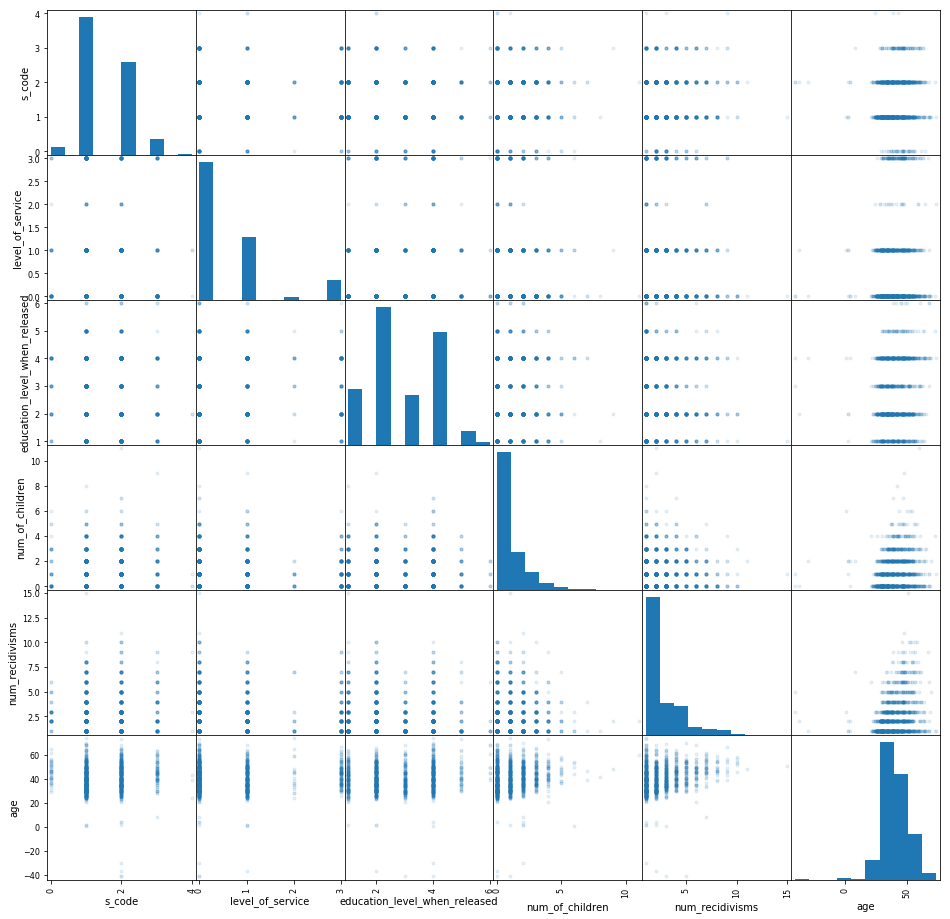

In [12]:
scatter_matrix(clean_df, figsize = (16,16), alpha=0.1)

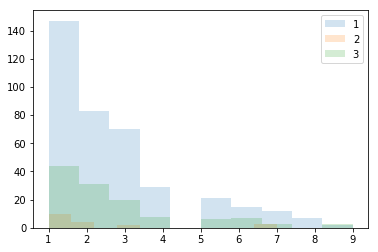

In [13]:
fig, ax = plt.subplots()
for los in range(1,4):
    ax.hist(clean_df[clean_df.level_of_service==los].num_recidivisms, alpha=0.2, label=str(los))
ax.legend()

In [ ]:
clean_df.plot(kind='box', figsize=(10,10))

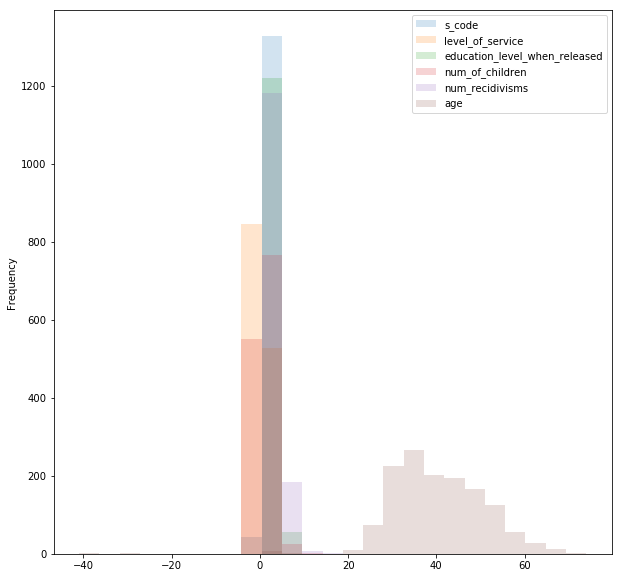

In [14]:
clean_df.plot(bins=25, alpha=0.2, kind='hist', figsize = (10,10))

In [15]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1374 entries, 127649.0 to nan
Data columns (total 11 columns):
full_name                        1373 non-null object
recidivism_event_name            1373 non-null object
s_code                           1369 non-null float64
level_of_service                 1373 non-null float64
education_level_when_released    1277 non-null float64
gender                           1330 non-null object
race_or_ethnicity                1238 non-null object
num_of_children                  1342 non-null float64
num_recidivisms                  1373 non-null float64
Birthdate                        1374 non-null object
age                              1374 non-null int64
dtypes: float64(5), int64(1), object(5)
memory usage: 128.8+ KB


In [16]:
clean_df.describe()

,s_code,level_of_service,education_level_when_released,num_of_children,num_recidivisms,age
count,1369.000000,1373.000000,1277.000000,1342.000000,1373.000000,1374.000000
mean,1.462381,0.575382,2.728269,1.143070,2.507647,40.238719
std,0.667933,0.897619,1.189264,1.311491,1.892360,10.822736
min,0.000000,0.000000,1.000000,0.000000,1.000000,-41.000000
25%,1.000000,0.000000,2.000000,0.000000,1.000000,33.000000
50%,1.000000,0.000000,2.000000,1.000000,2.000000,39.000000
75%,2.000000,1.000000,4.000000,2.000000,3.000000,47.000000
max,4.000000,3.000000,6.000000,11.000000,15.000000,74.000000


In [17]:
dummiess = pd.get_dummies(clean_df_norace, columns =['education_level_when_released', 'gender'])
dummiess.drop(['full_name', 'recidivism_event_name', 'Birthdate'], inplace = True, axis = 1)
x_norace = dummiess.dropna(axis = 0)

In [18]:
dummies = pd.get_dummies(clean_df, columns =['education_level_when_released', 'race_or_ethnicity', 'gender' ])

In [19]:
dummies.drop(['full_name', 'recidivism_event_name', 'Birthdate'], inplace = True, axis = 1)
x = dummies.dropna(axis = 0)

In [20]:
x.columns

Index(['s_code', 'level_of_service', 'num_of_children', 'num_recidivisms',
       'age', 'education_level_when_released_1.0',
       'education_level_when_released_2.0',
       'education_level_when_released_3.0',
       'education_level_when_released_4.0',
       'education_level_when_released_5.0',
       'education_level_when_released_6.0', 'race_or_ethnicity_Alaskan Native',
       'race_or_ethnicity_Alaskan Native; Caucasian',
       'race_or_ethnicity_Asian',
       'race_or_ethnicity_Asian; Black / African American',
       'race_or_ethnicity_Asian; Caucasian',
       'race_or_ethnicity_Asian; Caucasian; Native American',
       'race_or_ethnicity_Asian; Caucasian; Native Hawaiian / Pacific Islander',
       'race_or_ethnicity_Black / African American',
       'race_or_ethnicity_Black / African American; Caucasian',
       'race_or_ethnicity_Black / African American; Caucasian; Hispanic / Latino',
       'race_or_ethnicity_Black / African American; Caucasian; Native American',
 

In [21]:
ppep_clients = x[x.level_of_service == 3]
ppep_y  = ppep_clients['num_recidivisms'] > 1
ppep_clients.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [22]:
non_ppep_clients = x[x.level_of_service == 3]
non_ppep_y  = non_ppep_clients['num_recidivisms'] > 1
non_ppep_clients.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [23]:
y_norace  = x_norace['num_recidivisms'] > 1
x_norace.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
y  = x['num_recidivisms'] > 1
x.drop('num_recidivisms', inplace = True, axis = 1)

/home/rnjeri/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Fitting Scikit Learn Classification Models

In [25]:
'''
import classification modules
'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
x_norace.head()

In [26]:
'''
Fitting a logistic regression model to data that excludes race
'''
x_train,x_test, y_train, y_test = train_test_split(x_norace,y_norace)
lr = LogisticRegression()
lr_model = lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.62985074626865667

In [27]:
'''
Comparing to a logistic regresssion that includes race
'''
x_train,x_test, y_train, y_test = train_test_split(x,y)
lr = LogisticRegression()
lr_model = lr.fit(x_train, y_train)
lr.score(x_test, y_test)

0.58208955223880599

### Fitting Gradient Boosting Classifiers to PPEP students, and non PPEP students

In [28]:
ppepx_train, ppepx_test, ppepy_train, ppepy_test = train_test_split(ppep_clients, ppep_y)
gbc = GradientBoostingClassifier()
gbc_model_a = gbc.fit(ppepx_train, ppepy_train)
print (gbc_model_a.score(ppepx_test,ppepy_test))

0.758620689655


In [29]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
gbc = GradientBoostingClassifier()
gbc_model_ = gbc.fit(x_train, y_train)
print (gbc_model_.score(x_test, y_test))

0.638805970149


In [30]:
nonppepx_train, nonppepx_test, nonppepy_train, nonppepy_test = train_test_split(non_ppep_clients, non_ppep_y)
gbc = GradientBoostingClassifier()
gbc_model_b = gbc.fit(nonppepx_train, nonppepy_train)
print (gbc_model_b.score(nonppepx_test, nonppepy_test))

0.689655172414


In [31]:
rfc = RandomForestClassifier()
rfc_model = rfc.fit(x_train, y_train)
print (rfc_model.score(x_test, y_test))

0.585074626866


In [32]:
gbc = GradientBoostingClassifier()
gbc_model = gbc.fit(x_train, y_train)
print (gbc_model.score(x_test, y_test))

0.635820895522


In [33]:
clean_df.reset_index(inplace = True)

# Plotting ROC curves

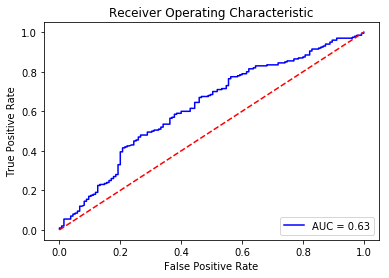

In [34]:
'''
This ROCurve uses the subset of data that contains people who applied to be served
by PPEP but received less than level 3 service
'''
y_predictprob_gbc_b = lr_model.predict_proba(x_test)
false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b, thresholds_gdc_model_b = roc_curve(y_test, y_predictprob_gbc_b[:,1])
roc_auc_gbc_b = auc(false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b)

##Plot ROC

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_gbc_model_b, true_positive_rate_gbc_model_b, 'b',
label='AUC = %0.2f'% roc_auc_gbc_b)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Comparing AUC for Random Forest and Gradient Boosting Classifiers

In [35]:
##Predicting classification probability for each model 
y_predictprob_rfc = rfc_model.predict_proba(x_test)
y_predictprob_gbc = gbc_model.predict_proba(x_test)

In [36]:
false_positive_rate_rfc, true_positive_rate_rfc, thresholds_rfc = roc_curve(y_test, y_predictprob_rfc[:,1])
false_positive_rate_gbc, true_positive_rate_gbc, thresholds_gbc = roc_curve(y_test, y_predictprob_gbc[:,1])

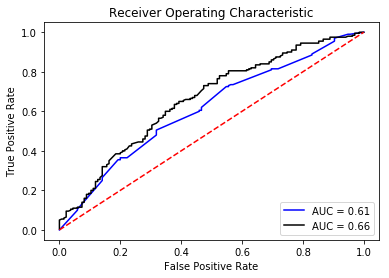

In [37]:
roc_auc_rfc = auc(false_positive_rate_rfc, true_positive_rate_rfc)
roc_auc_gbc = auc(false_positive_rate_gbc, true_positive_rate_gbc)

##Plot ROC

plt.title('Receiver Operating Characteristic')

plt.plot(false_positive_rate_rfc, true_positive_rate_rfc, 'b',
label='AUC = %0.2f'% roc_auc_rfc)

plt.plot(false_positive_rate_gbc, true_positive_rate_gbc, 'k',
label='AUC = %0.2f'% roc_auc_gbc)


plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## What is the Total Cost of Incarceration at Each Recidivism Rate?

The annual unit cost of incarceration is $51,775. What is the expected cost per person at each recidivism rate over a three year period? 

In [38]:
'''
A simulation estimating the aggregate cost of someone recidivating over a three year period
'''
##direct unit cost of incarceration per annum 
unit_cost = 51775
time_period = [1,2,3]

recidivism_probability_within_one_year = 13.7
recidivism_probability_within_two_years = 27.0
recidivism_probability_within_three_years = 34.9

'''
Estimated cost of incarceration while taking into account recidivism rate
'''
cost_if_recidivism_within_one_year = unit_cost * 3 * 0.137
print (0 + unit_cost * 2 * 0.27)
print (0 + 0 + unit_cost * 1 * 0.349)
total_cost = (unit_cost * 3 * 0.137)+ (0 + unit_cost * 2 * 0.27)+(0 + 0 + unit_cost * 1 * 0.349)
print ('Total cost with recidivism: {}'.format(total_cost))

27958.500000000004
18069.475
Total cost with recidivism: 67307.5


In [39]:
unit_cost = 51775 ##dollars per person per year
ppep_recidivism_rate = 0.078 
general_recidivism_rate = [0.085, 0.12, 0.079]
time_period = [1,2,3]

In [40]:
'''
calculating expected cost of incarceration for a randomly selected person
'''

def general_expected_cost_func():
    expected_cost = 0
    for recidivism_rate in general_recidivism_rate:
        expected_cost += unit_cost * recidivism_rate
    return expected_cost

'''
calculating the expected cost of incarceration with PPEP services
'''
def with_ppep_expected_cost_func():
    expected_cost = 0
    for year in range(3):
        expected_cost += unit_cost * ppep_recidivism_rate
    return expected_cost


### Estimating the Financial Gain of the Post Prison Education Program

In [41]:
print (general_expected_cost_func())
print (with_ppep_expected_cost_func())

14704.1
12115.349999999999


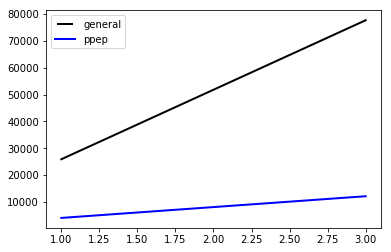

In [42]:
'''
plotting expected cost of incarceration per person depending 
'''
from matplotlib.legend_handler import HandlerLine2D
def plot_cost(recidivism = 0.5):
    cost = 51775
    x = [1,2,3]
    #recidivism = 0.278
    ppep_recidivism = 0.078
    y = [i * cost * recidivism for i in x]
    y2 = [i * cost* ppep_recidivism for i in x]
    line1, = plt.plot(x,y,label = 'general');
    line2, = plt.plot(x, y2, label = 'ppep')
    plt.setp(line1, color='k', linewidth=2.0)
    plt.setp(line2, color='b', linewidth=2.0)
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plot_cost(recidivism = 0.5)


## What Does the Confusion Matrix Reveal about Recidivism?

In [43]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    credits for confusion matrix code: http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
    """
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

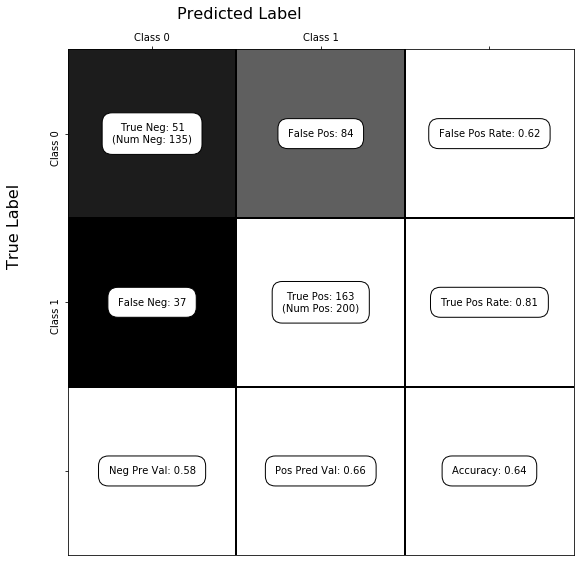

In [44]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test,gbc_model_.predict(x_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

### How Does the Model Perform within each Racial Group

In [45]:
df_afam = x_test[(x_test['race_or_ethnicity_Asian; Black / African American'] == 1)|(x_test['race_or_ethnicity_Black / African American'] ==1) | (x_test[ 'race_or_ethnicity_Black / African American; Caucasian'] ==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Black / African American; Hispanic / Latino'] ==1)|
       (x_test['race_or_ethnicity_Black / African American; Native American']==1)|
       (x_test['race_or_ethnicity_Black / African American; Native Hawaiian / Pacific Islander'] ==1)]

In [46]:
y_afam = y_test[(x_test['race_or_ethnicity_Asian; Black / African American'] == 1)|(x_test['race_or_ethnicity_Black / African American'] ==1) | (x_test[ 'race_or_ethnicity_Black / African American; Caucasian'] ==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Black / African American; Hispanic / Latino'] ==1)|
       (x_test['race_or_ethnicity_Black / African American; Native American']==1)|
       (x_test['race_or_ethnicity_Black / African American; Native Hawaiian / Pacific Islander'] ==1)]

In [47]:
x_white = x_test[(x_test['race_or_ethnicity_Alaskan Native; Caucasian'] ==1)|
        (x_test['race_or_ethnicity_Caucasian'] ==1)|
       (x_test['race_or_ethnicity_Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Caucasian; Hispanic / Latino; Native American']==1)|
       (x_test['race_or_ethnicity_Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Caucasian; Native Hawaiian / Pacific Islander']==1)|
        (x_test['race_or_ethnicity_Asian; Caucasian']==1)|
       (x_test['race_or_ethnicity_Asian; Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Asian; Caucasian; Native Hawaiian / Pacific Islander']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Native American']==1)]

In [48]:
y_white =y_test[(x_test['race_or_ethnicity_Alaskan Native; Caucasian'] ==1)|
        (x_test['race_or_ethnicity_Caucasian'] ==1)|
       (x_test['race_or_ethnicity_Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Caucasian; Hispanic / Latino; Native American']==1)|
       (x_test['race_or_ethnicity_Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Caucasian; Native Hawaiian / Pacific Islander']==1)|
        (x_test['race_or_ethnicity_Asian; Caucasian']==1)|
       (x_test['race_or_ethnicity_Asian; Caucasian; Native American']==1)|
       (x_test['race_or_ethnicity_Asian; Caucasian; Native Hawaiian / Pacific Islander']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Hispanic / Latino']==1)|
       (x_test['race_or_ethnicity_Black / African American; Caucasian; Native American']==1)]

### What is the Error of Race Specific Logistic Regression?

In [49]:
lr_model.score(x_white, y_white)

0.63594470046082952

In [50]:
lr_model.score(df_afam, y_afam)

0.65517241379310343

### Confusion matrix on people who self-identified as Caucasian 

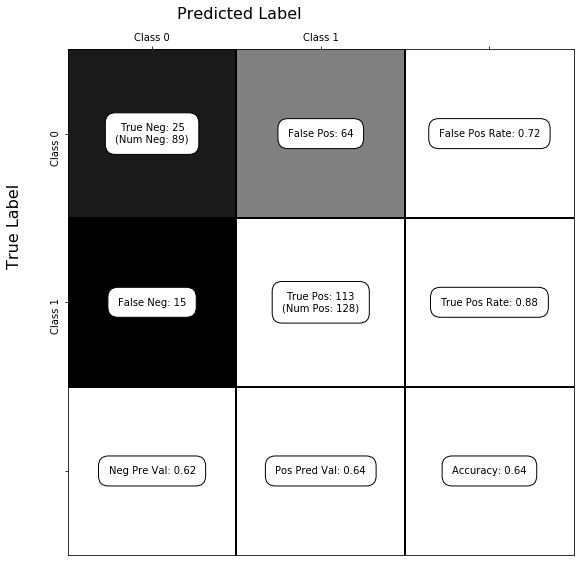

In [51]:
'''
confusion matrix for 'Caucasian'
'''
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_white,lr_model.predict(x_white))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

### Confusion matrix on people who self-identified as African American

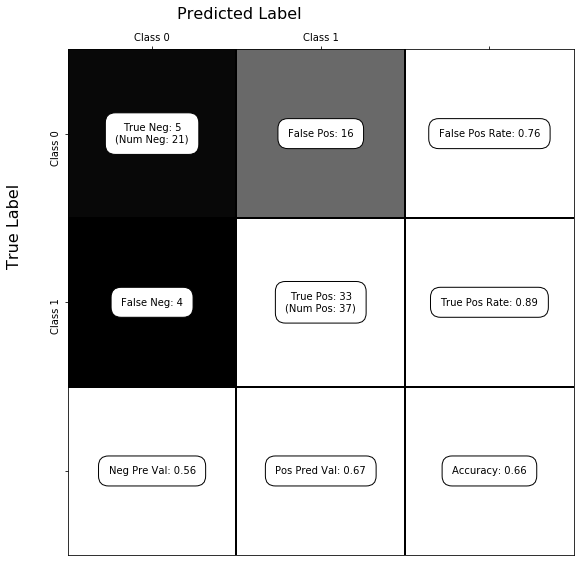

In [52]:
'''
confusion matrix for African Americans
'''
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_afam,lr_model.predict(df_afam))
show_confusion_matrix(C, ['Class 0', 'Class 1'])

### Confusion Matrix for the General Population

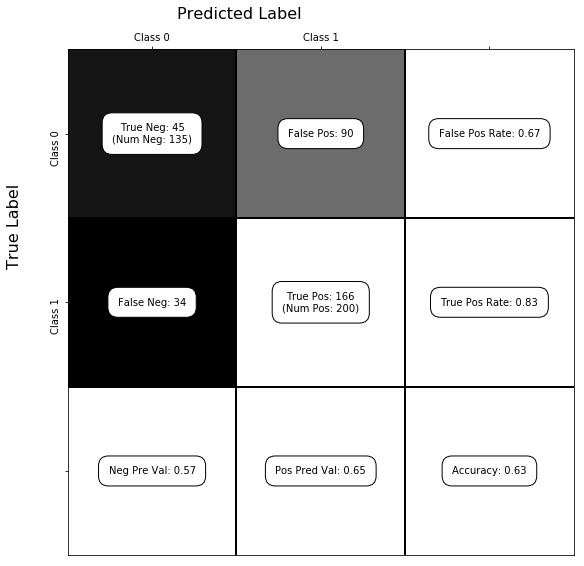

In [53]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(y_test,lr_model.predict(x_test))
show_confusion_matrix(C, ['Class 0', 'Class 1'])